In [1]:
import pandas as pd
import numpy as np
import string
import scipy as sp
from math import ceil
import seaborn as sns
from glob import glob
from Bio import pairwise2, SeqIO, Seq
import ternary
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import copy
import pycircos
from Bio.SeqUtils import GC
import textwrap
import math
import matplotlib.gridspec as gridspec
from itertools import combinations
import networkx as nx
import venn

sns.set_context(rc = {'legend.fontsize': 10, 'ytick.labelsize': 10, 'xtick.labelsize':10, 'axes.labelsize':10})
matplotlib.rcParams["font.family"] = "Arial"
OUT_DIR = '../../02-OUTPUT/06-ANALYSIS'
tss_df = pd.read_csv(f'{OUT_DIR}/tss_df.csv').query('dataset == "optimized"')

# multiple conditions contributing to TSS coverage

In [2]:
conditions = []
for gb in glob('../../02-OUTPUT/04-TSS/TSS_GBK/*.gb'):
    biovar = gb.split('/')[-1].split('-')[0]
    record = SeqIO.read(gb,format='genbank')
    for feature in record.features:
        if feature.type == 'TSS':
            strand = None
            if feature.location.strand == 1:
                strand = '+'
            elif feature.location.strand == -1:
                strand = '-'
            else:
                raise Exception(feature, strand, 'error')

            libs = feature.qualifiers['libs']
            libs = list(set([lib.replace(' ','') for lib in libs]))
            conditions.append([int(feature.location.end), strand, feature.qualifiers['ID'][0].split('_tss')[0], libs, biovar])
conditions_df = pd.DataFrame(conditions, columns=['TSS_position','TSS_strand','contig','TSS_conditions','biovar'])
conditions_df = tss_df.merge(conditions_df,on=['TSS_position','TSS_strand','contig','biovar'])
conditions_df['conditions_count'] = conditions_df['TSS_conditions'].apply(lambda x: len(x[0].split(',')))
conditions_df['TSS_conditions'] = conditions_df['TSS_conditions'].apply(lambda x: x[0].split(','))
# conditions_df['contig'] = conditions_df['contig'].map({'NC_003062.2':'Circular Chromosome', 'NC_003063.2':'Linear Chromosome', 'NC_003064.2':'At Plasmid', 'NC_003065.3':'Ti Plasmid'})
# conditions_df['contig'] = conditions_df['contig'].astype('category')
# conditions_df['contig'] = conditions_df['contig'].cat.set_categories(['Circular Chromosome', 'Linear Chromosome', 'At Plasmid', 'Ti Plasmid' ], ordered=True)

/home/lucas/anaconda3/lib/python3.9/site-packages/Bio/GenBank/__init__.py:359: BiopythonParserWarning: Attempting to fix invalid location '1967646..1967615' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(


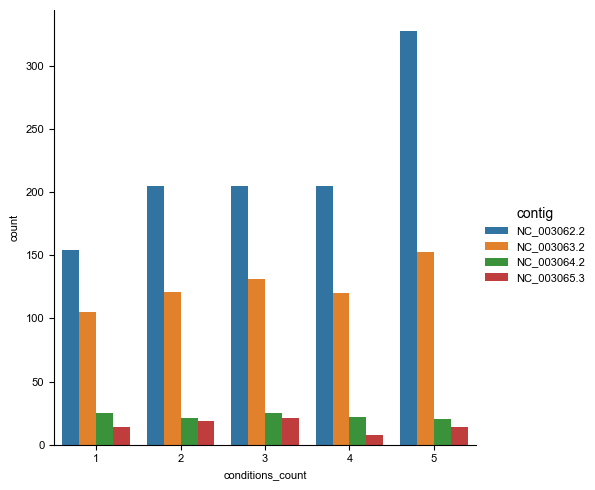

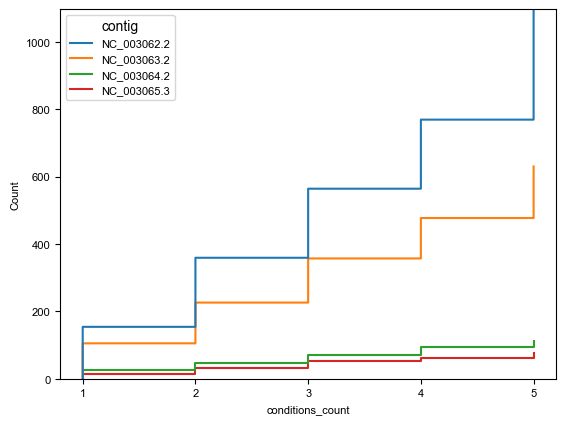

In [3]:
sns.catplot(kind='count',data=conditions_df.query('biovar=="BV1"').sort_values('contig'),x='conditions_count',hue='contig',sharey=False,sharex=False)
plt.show()

g = sns.ecdfplot(data=conditions_df.query('biovar=="BV1"').sort_values('contig'),x='conditions_count',hue='contig',stat='count')
g.set_xticks(range(1,6))
plt.show()


In [4]:

pita_log = conditions_df[conditions_df['TSS_conditions'].apply(lambda x: 'PITA_log' in x)].copy()
pita_stationary = conditions_df[conditions_df['TSS_conditions'].apply(lambda x: 'PITA_stationary' in x and 'PITA_log' not in x)].copy()
pita_induced = conditions_df[conditions_df['TSS_conditions'].apply(lambda x: 'PITA_induced' in x and 'PITA_stationary' not in x and 'PITA_log' not in x)].copy()
MOPS_glucose = conditions_df[conditions_df['TSS_conditions'].apply(lambda x: 'MOPS_glucose' in x and 'PITA_induced' not in x and 'PITA_stationary' not in x and 'PITA_log' not in x)].copy()
MOPS_succinate = conditions_df[conditions_df['TSS_conditions'].apply(lambda x: 'MOPS_succinate' in x and 'MOPS_glucose' not in x and 'PITA_induced' not in x and 'PITA_stationary' not in x and 'PITA_log' not in x)].copy()

# pita_log = pita_log.groupby('biovar').count().reset_index()[['biovar','Pos']].rename(columns={'Pos':'count'})
pita_log['condition'] = 'MGYS (log)'

# pita_stationary = pita_stationary.groupby('biovar').count().reset_index()[['biovar','Pos']].rename(columns={'Pos':'count'})
pita_stationary['condition'] = 'MGYS (stationary)'

# pita_induced = pita_induced.groupby('biovar').count().reset_index()[['biovar','Pos']].rename(columns={'Pos':'count'})
pita_induced['condition'] = 'MGYS (induced)'

# MOPS_glucose = MOPS_glucose.groupby('biovar').count().reset_index()[['biovar','Pos']].rename(columns={'Pos':'count'})
MOPS_glucose['condition'] = 'MOPS+glucose'

# MOPS_succinate = MOPS_succinate.groupby('biovar').count().reset_index()[['biovar','Pos']].rename(columns={'Pos':'count'})
MOPS_succinate['condition'] = 'MOPS+succinate'

test = pd.concat([ pita_log, pita_stationary, pita_induced, MOPS_glucose, MOPS_succinate ]).reset_index(drop=True)
test['condition'] = test['condition'].astype('category')
test['condition'] = test['condition'].cat.set_categories(['MGYS (log)', 'MGYS (stationary)', 'MGYS (induced)','MOPS+glucose', 'MOPS+succinate'], ordered=True)


In [5]:
# nodes = ['PITA_log', 'PITA_stationary', 'PITA_induced','MOPS_glucose', 'MOPS_succinate']
# label_map = {'PITA_log':'MGYS (log)', 'PITA_stationary':'MGYS (stationary', 'PITA_induced':'MGYS (induced)','MOPS_glucose':'MOPS+glucose', 'MOPS_succinate':'MOPS+succinate'}
# for bv in conditions_df['biovar'].unique():
#     tmp = conditions_df.query(f'biovar == "{bv}" and TSS_class == "primary"').copy()
#     edges = combinations(nodes,2)
#     g = nx.Graph()
#     g.add_nodes_from(nodes)
#     g.add_edges_from(edges)

#     plt.figure(figsize=(4,5))
#     nx.draw(g,
#         with_labels=True,
#         pos=nx.circular_layout(g),
#         node_size=[ len(tmp[tmp['TSS_conditions'].apply(lambda x: len(x) == 1 and k in x)])*30 for k in dict(g.nodes()).keys()],
#         width=[ len(tmp[tmp['TSS_conditions'].apply(lambda x: len(x) == 2 and combo[0] in x and combo[1] in x)])/7 for combo in dict(g.edges()).keys()],
#         labels={k:len(tmp[tmp['TSS_conditions'].apply(lambda x: len(x) == 1 and k in x)]) for k in dict(g.nodes()).keys() }
#         )
#     nx.draw_networkx_edge_labels(g,
#         pos=nx.circular_layout(g),
#         edge_labels={combo:len(tmp[tmp['TSS_conditions'].apply(lambda x: len(x) == 2 and combo[0] in x and combo[1] in x)]) for combo in dict(g.edges()).keys()})
#     plt.savefig(f'{OUT_DIR}/{bv}_network_numbersonly.png',dpi=300,bbox_inches='tight')

fig = plt.figure(tight_layout=True,figsize=(8,6.5))
gs = gridspec.GridSpec(1,3,hspace=0.0)
CROP=10
ax = fig.add_subplot(gs[0, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/BV1_network_numbersonly.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
plt.title('BV1')
ax = fig.add_subplot(gs[0, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/BV2_network_numbersonly.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
plt.title('BV2')

ax = fig.add_subplot(gs[0, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/BV3_network_numbersonly.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
plt.title('BV3')
plt.savefig(f'{OUT_DIR}/network_analysis_numbersonly.png',dpi=300,bbox_inches='tight')



In [7]:
# fig = plt.figure(figsize=(8,4))
# g = sns.histplot(data=test, x='condition',hue='biovar',cumulative=True, element='step',fill=False)
# g.set_xlabel('Condition')
# g.legend_.set_title(None)
# g.legend_.set_frame_on(False)
# g.set_yticks(range(0,3250,250))
# sns.despine()

fig = plt.figure(figsize=(8,4))
g = sns.histplot(data=test.query('TSS_class == "primary"'), x='condition',hue='biovar',cumulative=True,fill=False)
g.set_xlabel('Condition')
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_yticks(range(0,2250,250))
sns.despine()

In [8]:
conditions = ['PITA_log', 'PITA_stationary', 'PITA_induced','MOPS_glucose', 'MOPS_succinate']
label_map = {'PITA_log':'MGYS (log)', 'PITA_stationary':'MGYS (stationary)', 'PITA_induced':'MGYS (induced)','MOPS_glucose':'MOPS+glucose', 'MOPS_succinate':'MOPS+succinate'}
for i in range(1,4):
    tmp = conditions_df.query(f'biovar == "BV{i}"').copy()
    sets = []
    for condition in conditions:
        mask = tmp['TSS_conditions'].apply(lambda x: condition in x)
        tmp['conditions_str'] = tmp['TSS_conditions'].apply(lambda x: '-'.join(x))
        sets.append( set(tmp[mask].apply(lambda row: f"{row['biovar']}-{row['contig']}-{row['TSS_position']}-{row['TSS_strand']}-{row['conditions_str']}",axis=1)))
    pd.DataFrame(sets,index=conditions).T.to_csv(f'{OUT_DIR}/BV{i}_condition_sets_allTSS.csv',sep=',',index=False)
    plt.figure(figsize=(15,10))
    labels = venn.get_labels(sets)
    fig, ax = venn.venn5(labels, names=label_map.values())
    fig.savefig(f'{OUT_DIR}/BV{i}_venn_diagram.png',dpi=600,bbox_inches='tight')
    fig.show()

fig = plt.figure(tight_layout=True,figsize=(8,6.5))
gs = gridspec.GridSpec(1,3,hspace=0.0)
CROP=10
ax = fig.add_subplot(gs[0, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/BV1_venn_diagram.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
plt.title('BV1')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/BV2_venn_diagram.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
plt.title('BV2')

ax = fig.add_subplot(gs[0, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/BV3_venn_diagram.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
plt.title('BV3')

fig.savefig(f'{OUT_DIR}/venn_diagrams',dpi=300,bbox_inches='tight')

/home/lucas/anaconda3/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/lucas/anaconda3/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((
/home/lucas/anaconda3/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/lucas/anaconda3/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((
/home/lucas/anaconda3/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_peta

Query induction conditions

In [9]:
x = conditions_df.query('TSS_class == "primary" or TSS_class == "secondary"').copy()
x = x[x['TSS_conditions'].apply(lambda conditions: len(conditions) == 1 and "PITA_induced" in conditions)].drop_duplicates(subset='TSS_locus_tag').reset_index(drop=True)
x

ortho_df = pd.read_csv('../../02-OUTPUT/05-PIRATE/orthologous_clustering.csv')[['consensus_gene_name','consensus_product','products','BV1','BV2','BV3']]
df = pd.concat([
    x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV1"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV1']),
    x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV2"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV2']),
    x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV3"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV3'])]).reset_index(drop=True)
bv1 = set(df.query('biovar == "BV1"')['BV1'])
bv2 = set(df.query('biovar == "BV2"')['BV1'])
bv3 = set(df.query('biovar == "BV3"')['BV1'])
v = venn3_unweighted(subsets=(bv1,bv2,bv3), set_labels=('A. fabrum C58','R. rhizogenes C16/80','A. vitis T60/94'),alpha=0.6)

for idx, row in df.iterrows():
    df.loc[idx, 'in_BV1'] = row['BV1'] in bv1
    df.loc[idx, 'in_BV2'] = row['BV1'] in bv2
    df.loc[idx, 'in_BV3'] = row['BV1'] in bv3
    df.loc[idx, 'in_BV1_BV2'] = row['BV1'] in bv1 and row['BV1'] in bv2
    df.loc[idx, 'in_BV1_BV3'] = row['BV1'] in bv1 and row['BV1'] in bv3
    df.loc[idx, 'in_BV2_BV3'] = row['BV1'] in bv2 and row['BV1'] in bv3
    df.loc[idx, 'in_BV1_BV2_BV3'] = row['BV1'] in bv1 and row['BV1'] in bv2 and row['BV1'] in bv3
df = df.drop(columns=['TSS_locus_tag']).rename(columns={'biovar':'biovar_dataset','contig':'primary_secondary_TSS_count'}).reset_index(drop=True)
df = df.drop_duplicates('BV1')
df

,biovar_dataset,primary_secondary_TSS_count,consensus_gene_name,consensus_product,products,BV1,BV2,BV3,in_BV1,in_BV2,in_BV3,in_BV1_BV2,in_BV1_BV3,in_BV2_BV3,in_BV1_BV2_BV3
0,BV1,NC_003062.2,mepA,penicillin-insensitive murein endopeptidase,penicillin-insensitive murein endopeptidase(96...,Atu0186,MDIPDJ_18060,FLNPIO_17590,True,False,False,False,False,False,False
1,BV1,NC_003062.2,appA,ABC transporter substrate-binding protein,ABC transporter substrate-binding protein(932)...,Atu0187,MDIPDJ_18070,FLNPIO_17595,True,False,False,False,False,False,False
2,BV1,NC_003062.2,NaN,Flp pilus assembly protein CpaB,Flp pilus assembly protein CpaB(962):SAF domai...,Atu0222,MDIPDJ_18295,FLNPIO_17510,True,False,False,False,False,False,False
3,BV1,NC_003062.2,gstB,glutathione S-transferase family protein,glutathione S-transferase family protein(932):...,Atu0293,MDIPDJ_19225,FLNPIO_17960,True,False,False,False,False,False,False
4,BV1,NC_003062.2,galE,UDP-glucose 4-epimerase GalE,UDP-glucose 4-epimerase GalE(953):UDP-glucose ...,Atu0530,MDIPDJ_00890,FLNPIO_00865,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,BV3,chromosome,NaN,hypothetical protein,hypothetical protein(1467):BrnA antitoxin fami...,Atu0467,MDIPDJ_21200,FLNPIO_17455,False,False,True,False,False,False,False
3368,BV3,chromosome,NaN,hypothetical protein,hypothetical protein(1467):BrnA antitoxin fami...,Atu0789,MDIPDJ_21200,FLNPIO_17455,False,False,True,False,False,False,False
3369,BV3,chromosome,NaN,hypothetical protein,hypothetical protein(1467):BrnA antitoxin fami...,Atu5440,MDIPDJ_21200,FLNPIO_17455,False,False,True,False,False,False,False
3370,BV3,chromosome,ohrR,MarR family transcriptional regulator,MarR family transcriptional regulator(952):Org...,Atu0109,MDIPDJ_17940,FLNPIO_17805,False,False,True,False,False,False,False


In [10]:
covered = df['BV1'].to_list()

In [11]:
x = conditions_df.copy()
x = x[x['TSS_conditions'].apply(lambda conditions: len(conditions) == 1 and "PITA_induced" in conditions)].drop_duplicates(subset='TSS_locus_tag').reset_index(drop=True)
x

ortho_df = pd.read_csv('../../02-OUTPUT/05-PIRATE/orthologous_clustering.csv')[['consensus_gene_name','consensus_product','products','BV1','BV2','BV3']]
df = pd.concat([
    x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV1"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV1']),
    x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV2"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV2']),
    x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV3"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV3'])]).reset_index(drop=True)
bv1 = set(df.query('biovar == "BV1"')['BV1'])
bv2 = set(df.query('biovar == "BV2"')['BV1'])
bv3 = set(df.query('biovar == "BV3"')['BV1'])
v = venn3_unweighted(subsets=(bv1,bv2,bv3), set_labels=('A. fabrum C58','R. rhizogenes C16/80','A. vitis T60/94'),alpha=0.6)

for idx, row in df.iterrows():
    df.loc[idx, 'in_BV1'] = row['BV1'] in bv1
    df.loc[idx, 'in_BV2'] = row['BV1'] in bv2
    df.loc[idx, 'in_BV3'] = row['BV1'] in bv3
    df.loc[idx, 'in_BV1_BV2'] = row['BV1'] in bv1 and row['BV1'] in bv2
    df.loc[idx, 'in_BV1_BV3'] = row['BV1'] in bv1 and row['BV1'] in bv3
    df.loc[idx, 'in_BV2_BV3'] = row['BV1'] in bv2 and row['BV1'] in bv3
    df.loc[idx, 'in_BV1_BV2_BV3'] = row['BV1'] in bv1 and row['BV1'] in bv2 and row['BV1'] in bv3
df = df.drop(columns=['TSS_locus_tag']).rename(columns={'biovar':'biovar_dataset','contig':'primary_secondary_TSS_count'}).reset_index(drop=True)
df = df.drop_duplicates('BV1')


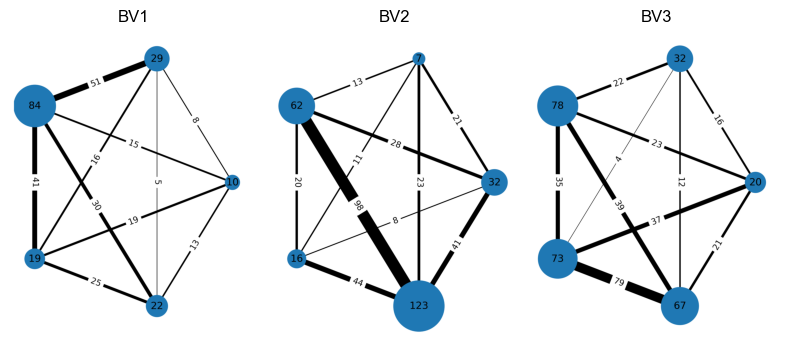

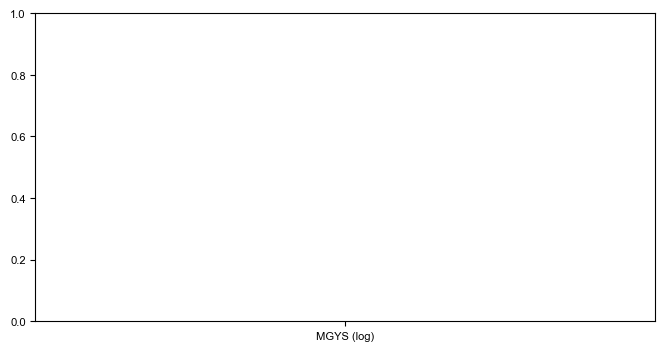

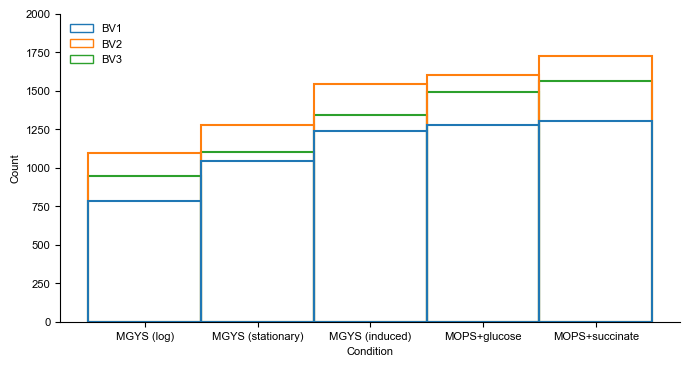

<Figure size 1500x1000 with 0 Axes>

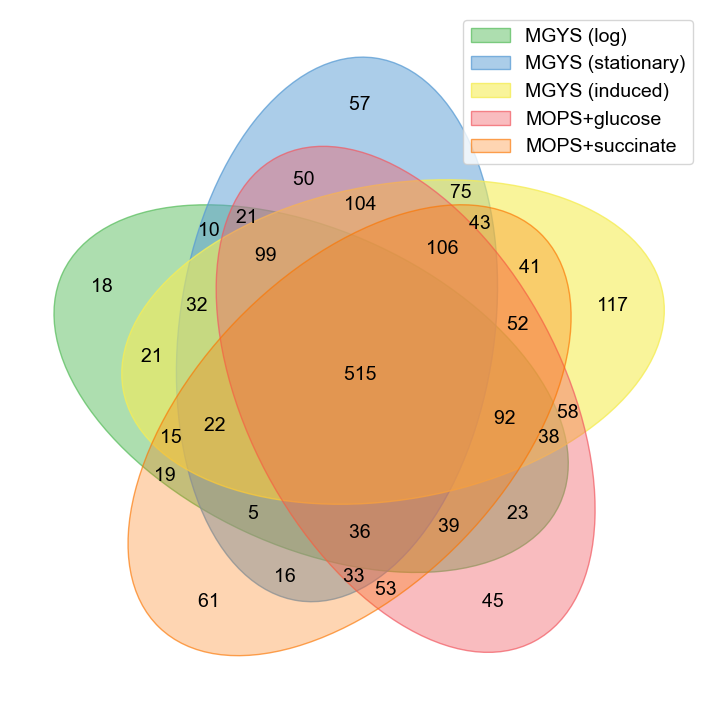

<Figure size 1500x1000 with 0 Axes>

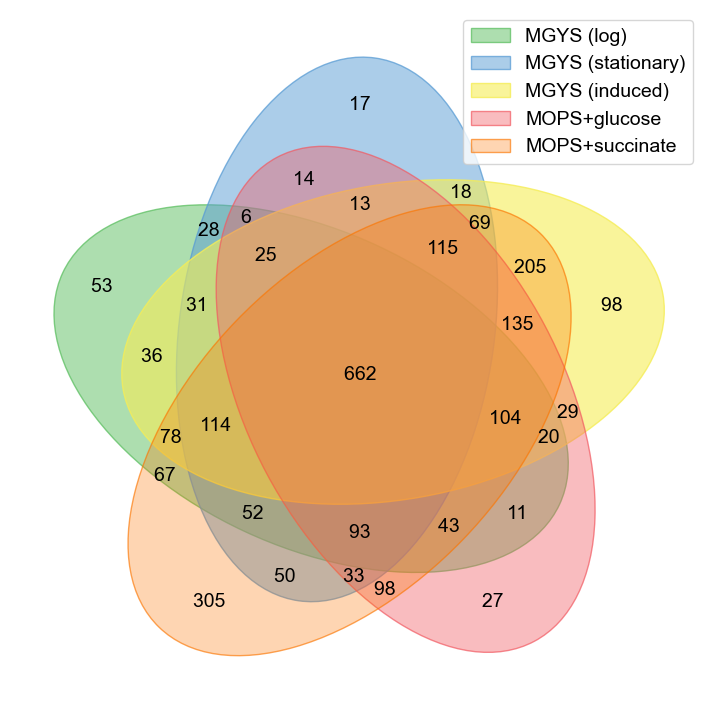

<Figure size 1500x1000 with 0 Axes>

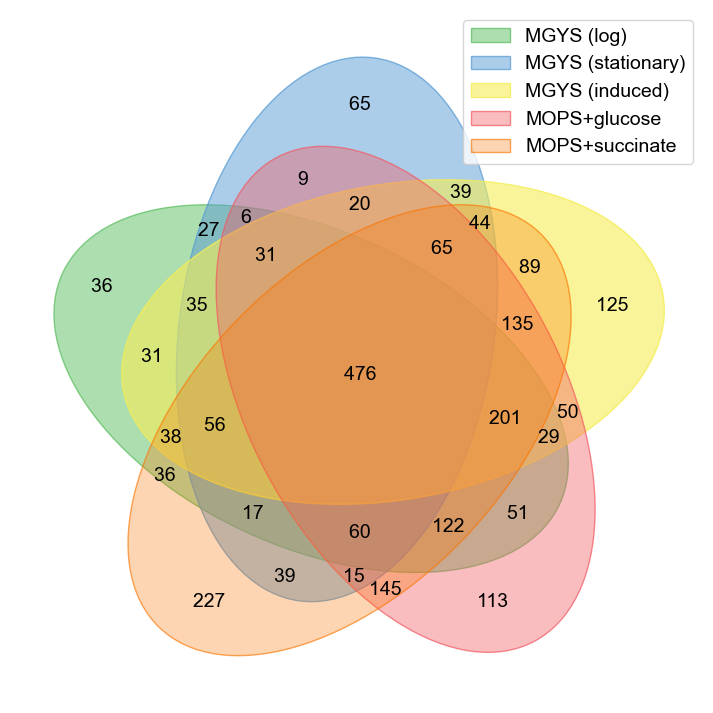

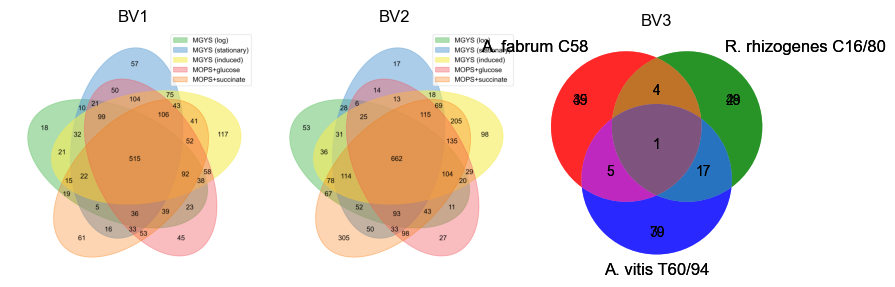

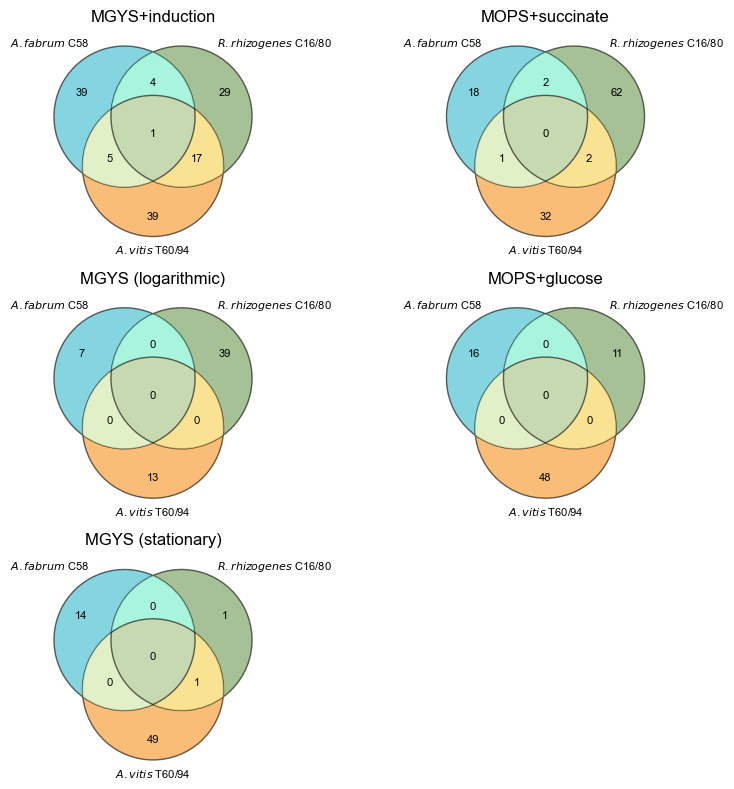

In [12]:
primary = '#33B9CB'
secondary = '#6A994E'
tertiary = '#F5911F'

fig = plt.figure(tight_layout=True,figsize=(8,8))
gs = gridspec.GridSpec(3,2)


def get_condition_sets(condition):
    x = conditions_df.query('TSS_class == "primary" or TSS_class == "secondary"').copy()
    x = x[x['TSS_conditions'].apply(lambda conditions: len(conditions) == 1 and condition in conditions)].drop_duplicates(subset='TSS_locus_tag').reset_index(drop=True)

    ortho_df = pd.read_csv('../../02-OUTPUT/05-PIRATE/orthologous_clustering.csv')[['consensus_gene_name','consensus_product','products','BV1','BV2','BV3']]
    df = pd.concat([
        x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV1"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV1']),
        x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV2"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV2']),
        x[['biovar','TSS_locus_tag','contig']].query('biovar == "BV3"').merge(ortho_df,left_on=['TSS_locus_tag'],right_on=['BV3'])]).reset_index(drop=True)
    bv1 = set(df.query('biovar == "BV1"')['BV1'])
    bv2 = set(df.query('biovar == "BV2"')['BV1'])
    bv3 = set(df.query('biovar == "BV3"')['BV1'])

    return bv1,bv2,bv3

def fancify_venn3(v):
    for i in range(len(v.patches)):
        if i in [0,1,3,6,7]:
            patch = v.patches[i]
            patch.set_edgecolor("black")
            patch.set_lw(1)
        for text in v.set_labels:
            text.set_fontsize(8)
        for x in range(len(v.subset_labels)):
            if v.subset_labels[x] is not None:
                v.subset_labels[x].set_fontsize(8)

v = venn3_unweighted(subsets=(get_condition_sets('PITA_induced')),
                     set_labels = (r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'), 
                    #  set_labels = ('','',''),
                     set_colors=[primary,secondary,tertiary],
                     alpha=0.6,
                     ax=fig.add_subplot(gs[0, 0]))
plt.title('MGYS+induction')
fancify_venn3(v)

v = venn3_unweighted(subsets=(get_condition_sets('PITA_log')),
                     set_labels = (r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'), 
                    #  set_labels = ('','',''),
                     set_colors=[primary,secondary,tertiary],
                     alpha=0.6,
                     ax=fig.add_subplot(gs[1, 0]))
plt.title('MGYS (logarithmic)')
fancify_venn3(v)

v = venn3_unweighted(subsets=(get_condition_sets('PITA_stationary')),
                     set_labels = (r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'), 
                    #  set_labels = ('','',''),
                     set_colors=[primary,secondary,tertiary],
                     alpha=0.6,
                     ax=fig.add_subplot(gs[2, 0]))
plt.title('MGYS (stationary)')
fancify_venn3(v)

v = venn3_unweighted(subsets=(get_condition_sets('MOPS_succinate')),
                     set_labels = (r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'), 
                    #  set_labels = ('','',''),
                     set_colors=[primary,secondary,tertiary],
                     alpha=0.6,
                     ax=fig.add_subplot(gs[0, 1]))
plt.title('MOPS+succinate')
fancify_venn3(v)

v = venn3_unweighted(subsets=(get_condition_sets('MOPS_glucose')),
                     set_labels = (r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'), 
                    #  set_labels = ('','',''),
                     set_colors=[primary,secondary,tertiary],
                     alpha=0.6,
                     ax=fig.add_subplot(gs[1, 1]))
plt.title('MOPS+glucose')
fancify_venn3(v)
fig.savefig(f'{OUT_DIR}/all_venn_diagrams.png',dpi=600,bbox_inches='tight')
plt.show()
# for idx, row in df.iterrows():
#     df.loc[idx, 'in_BV1'] = row['BV1'] in bv1
#     df.loc[idx, 'in_BV2'] = row['BV1'] in bv2
#     df.loc[idx, 'in_BV3'] = row['BV1'] in bv3
#     df.loc[idx, 'in_BV1_BV2'] = row['BV1'] in bv1 and row['BV1'] in bv2
#     df.loc[idx, 'in_BV1_BV3'] = row['BV1'] in bv1 and row['BV1'] in bv3
#     df.loc[idx, 'in_BV2_BV3'] = row['BV1'] in bv2 and row['BV1'] in bv3
#     df.loc[idx, 'in_BV1_BV2_BV3'] = row['BV1'] in bv1 and row['BV1'] in bv2 and row['BV1'] in bv3
# df = df.drop(columns=['TSS_locus_tag']).rename(columns={'biovar':'biovar_dataset','contig':'primary_secondary_TSS_count'}).reset_index(drop=True)
# df = df.drop_duplicates('BV1')

In [14]:
conditions_df

,biovar,contig,TSS_position,TSS_strand,TSS_locus_tag,TSS_class,TSS_promoter,UTR_length,gene_length,putative_sRNA,putative_asRNA,dataset,TSS_conditions,conditions_count
0,BV1,NC_003062.2,3069,+,Atu0005,primary,TCGATTCGGGAAATGGTGTCGAAGCGGCACGGGATCAGGTAAAAGA...,41.0,699.0,0,0,optimized,"[MOPS_glucose, MOPS_succinate, PITA_induced]",3
1,BV1,NC_003062.2,4415,-,Atu0006,primary,GCGATCAGGAAGGGTTGTAAGCCCCGGGTCGAAATGATAGACCGCC...,26.0,483.0,0,0,optimized,"[MOPS_glucose, MOPS_succinate, PITA_induced, P...",4
2,BV1,NC_003062.2,6947,+,Atu0010,primary,GAGCTTGCCGGCACGGTGCGCAACGAAGCCGATTTTTATATACTGC...,27.0,570.0,0,0,optimized,[MOPS_succinate],1
3,BV1,NC_003062.2,9614,-,Atu0012,antisense,ATCAGTTCCGGCATCTGGCGGAAGAAGAAGGTCAATAGTAGGGTAC...,NaN,2436.0,0,1,optimized,"[MOPS_glucose, PITA_stationary]",2
4,BV1,NC_003062.2,11306,+,Atu0014,primary,TGGCGCAGTCAAGGGGTGACAAGTATGAATGCATCGTTCATATATG...,29.0,843.0,0,1,optimized,"[MOPS_glucose, MOPS_succinate, PITA_induced, P...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,BV3,chromosome,3811561,-,FLNPIO_18140,primary,TTACTCGATCTTAACTTGCCGGATATGTCGGGCACCGATATACTCG...,205.0,1035.0,0,0,optimized,"[MOPS_glucose, MOPS_succinate, PITA_induced, P...",4
6993,BV3,chromosome,3815866,-,FLNPIO_18160,primary,TACGGTTTCCACCTCTGGTAATTCCGGCATGAAGGCTCCATGTTTC...,159.0,777.0,0,1,optimized,"[MOPS_glucose, MOPS_succinate, PITA_log, PITA_...",4
6994,BV3,chromosome,3816894,+,FLNPIO_18170,primary,GTTGAGAAAGCGCGTTGACGACGCCGTTCTTTCCCGCTATATGCCC...,113.0,267.0,0,0,optimized,"[MOPS_glucose, MOPS_succinate, PITA_induced, P...",5
6995,BV3,chromosome,3817673,+,orphan,orphan,GGTAAAATTCATTGTTGATCTCGGCATTCGATCCTGCCTAAATGCA...,NaN,NaN,0,0,optimized,"[MOPS_glucose, MOPS_succinate, PITA_induced, P...",5


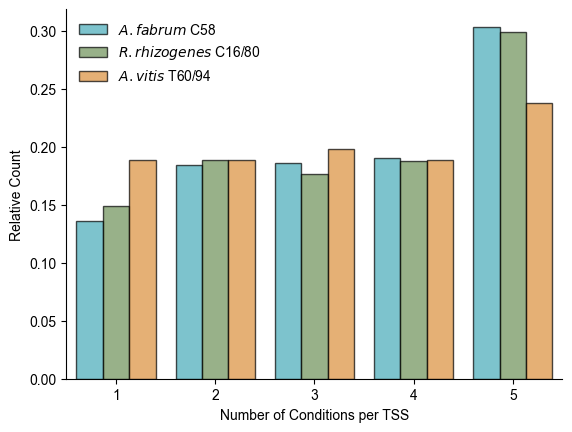

In [30]:
sns.set_context(rc = {'legend.fontsize': 10, 'ytick.labelsize': 10, 'xtick.labelsize':10, 'axes.labelsize':10})

df = conditions_df.query('TSS_class == "primary" or TSS_class == "secondary"')
x = df.groupby(['biovar','conditions_count']).count().reset_index()[['biovar','conditions_count','contig']].rename(columns={'contig':'count'})
y = df.groupby(['biovar']).count().reset_index()[['biovar','contig']].rename(columns={'contig':'TSS_count'})
x = x.merge(y,on='biovar')
x['rel_count'] = x['count'] / x['TSS_count']
x['biovar_name'] = x['biovar'].map({'BV1':r'$\it{A. fabrum}$ C58','BV2':r'$\it{R. rhizogenes}$ C16/80','BV3':r'$\it{A. vitis}$ T60/94'})
g = sns.barplot(data=x, x='conditions_count',y='rel_count',hue='biovar_name',alpha=0.7,edgecolor="black",linewidth=1.0,palette=[primary,secondary,tertiary])
g.set_xlabel('Number of Conditions per TSS')
g.set_ylabel('Relative Count')
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
sns.despine()
plt.savefig(f'{OUT_DIR}/07-condition_count_per_tss.png',dpi=600,bbox_inches='tight',transparent=False)
plt.show()

In [25]:
x

,biovar,conditions_count,count,TSS_count,rel_count,biovar_name
0,BV1,1,190,1401,0.135617,$\it{A. fabrum}$ C58
1,BV1,2,258,1401,0.184154,$\it{A. fabrum}$ C58
2,BV1,3,261,1401,0.186296,$\it{A. fabrum}$ C58
3,BV1,4,267,1401,0.190578,$\it{A. fabrum}$ C58
4,BV1,5,425,1401,0.303355,$\it{A. fabrum}$ C58
5,BV2,1,274,1839,0.148994,$\it{R. rhizogenes}$ C16/80
6,BV2,2,346,1839,0.188146,$\it{R. rhizogenes}$ C16/80
7,BV2,3,325,1839,0.176726,$\it{R. rhizogenes}$ C16/80
8,BV2,4,345,1839,0.187602,$\it{R. rhizogenes}$ C16/80
9,BV2,5,549,1839,0.298532,$\it{R. rhizogenes}$ C16/80


In [ ]:
conditions_df['TSS_conditions'][6994]

In [ ]:
x.query('condition_count == 5')